# Drone Images Segmentation Using SegNet

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install torchmetrics

In [51]:
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision import tv_tensors
from torch.utils.data import Dataset, DataLoader
from torchmetrics.segmentation import DiceScore, MeanIoU
from torchvision.transforms.functional import InterpolationMode

from sklearn.model_selection import train_test_split

import os
import time
import random
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Reproducibilty Settings

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Computation Device: ", device)

Computation Device:  cuda


In [53]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if device == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Dataset Class

In [54]:
class DroneImagesSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, filenames, joint_transforms=None, image_transforms=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.filenames = filenames
        self.joint_transforms = joint_transforms
        self.image_transforms = image_transforms

        # Lookup table for the classes present in the mask
        original_classes = [0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22]
        self.lookup_table = np.zeros(23, dtype=np.int64)
        for new_index, orig_val in enumerate(original_classes):
            self.lookup_table[orig_val] = new_index


    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        img_filename, mask_filename = self.filenames[index]
        
        image_path = os.path.join(self.images_dir, img_filename)
        mask_path = os.path.join(self.masks_dir, mask_filename)
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Remap the mask pixel values before creating the tensor
        mask_array = np.array(mask)
        remapped_masked = self.lookup_table[mask_array]

        image = tv_tensors.Image(image)
        mask = tv_tensors.Mask(remapped_masked)

        if self.joint_transforms:
            image, mask = self.joint_transforms(image, mask)
        
        if self.image_transforms:
            image = self.image_transforms(image)
        
        mask = mask.to(torch.long)

        # Remove channel dimension for Cross Entropy
        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask.squeeze(0)

        return image, mask

# Helper Functions

In [55]:
def get_transforms(is_train=True):
    
    if is_train: 
        # Joint Spatial Transforms For Both Images & Masks
        joint_transforms = v2.Compose([
            v2.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
            
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),

            v2.RandomRotation(
                degrees=45,
                interpolation=InterpolationMode.NEAREST
            ),

            v2.RandomResizedCrop(
                size=(256, 256),
                scale=(0.8, 1.0),
                interpolation=InterpolationMode.NEAREST
            ),
            
            v2.ToImage(), # Image to tensor (Modern ToTensor() Alternative)
            v2.ToDtype(torch.float32, scale=True)
        ])

        # Image Only Transforms
        image_transforms = v2.Compose([
            v2.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2
            ),
            v2.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    else:
        joint_transforms = v2.Compose([
            v2.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
        ])

        image_transforms = v2.Compose([
            v2.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    return joint_transforms, image_transforms

In [56]:
def get_loaders(images_dir, masks_dir, batch_size=8):
    
    # Initialize Transforms
    train_joint_transforms, train_image_transforms = get_transforms(is_train=True)
    val_test_joint_transforms, val_test_image_transforms = get_transforms(is_train=False)


    # --- Note to future me: ONLY use this logic when both images and masks are identical in name ---
    # # Ensure only matching image/mask pairs are used
    # all_images = set(os.listdir(images_dir))
    # all_masks = set(os.listdir(masks_dir))
    # paired_filenames = sorted(list(all_images & all_masks))

    # --- New Logic ---
    paired_filenames = []
    for img_name in sorted(os.listdir(images_dir)):
        if img_name.startswith('.'):
            continue
        
        # Get the filename without the extension
        base_name = os.path.splitext(img_name)[0]
        
        mask_name = base_name + ".png"

        if os.path.exists(os.path.join(masks_dir, mask_name)):
            paired_filenames.append((img_name, mask_name))
        
    print(f"Found {len(paired_filenames)} valid image-mask pairs!")

    if len(paired_filenames) < 10:
        raise ValueError("Not enough paired files found! Check your folder paths and file extensions.")
        

    # Split filenames before creating datasets
    train_files, val_test_files = train_test_split(
        paired_filenames, test_size=0.2, random_state=42
    )

    val_files, test_files = train_test_split(
        val_test_files, test_size=0.5, random_state=42
    )

    # Create Datasets
    train_dataset = DroneImagesSegmentationDataset(
        images_dir, masks_dir, train_files, train_joint_transforms, train_image_transforms
    )

    val_dataset = DroneImagesSegmentationDataset(
        images_dir, masks_dir, val_files, val_test_joint_transforms, val_test_image_transforms
    )

    test_dataset = DroneImagesSegmentationDataset(
        images_dir, masks_dir, test_files, val_test_joint_transforms, val_test_image_transforms
    )

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [57]:
def get_metrics(num_classes, device):
    metrics = torchmetrics.MetricCollection({
        "dice": DiceScore(
            num_classes=num_classes, include_background=True, average=None, input_format="index"
        ),
        "miou": MeanIoU(
            num_classes=num_classes, include_background=True, per_class=True, input_format="index"
        ),
        "pixel_acc": torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        ),
        "conf_mat": torchmetrics.ConfusionMatrix(
            task="multiclass", num_classes=num_classes, normalize="true" # Normalizes over true labels
        )
    }).to(device)

    return metrics

In [58]:
class DiceCELoss(nn.Module):
    def __init__(self, ce_weight=1.0, dice_weight=1.0, epsilon=1e-6):
        super(DiceCELoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.epsilon = epsilon
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # Compute CE Loss (Numerically stable)
        ce = self.ce_loss(inputs, targets)

        # Apply Softmax to raw predictions
        inputs = torch.softmax(inputs, dim=1)

        # One-Hot encode the targets
        targets = F.one_hot(targets, num_classes=inputs.shape[1])
        targets = targets.permute(0, 3, 1, 2).float()

        # Flatten the tensors
        inputs = inputs.view(inputs.shape[0], inputs.shape[1], -1)
        targets = targets.view(targets.shape[0], targets.shape[1], -1)

        # Compute Dice Loss
        intersection = (inputs * targets).sum(dim=2)
        union = inputs.sum() + targets.sum(dim=2)

        dice_score = (2.0 * intersection + self.epsilon) / (union + self.epsilon)
        dice_loss = 1 - dice_score.mean()

        dice_ce_loss = (ce * self.ce_weight) + (dice_loss * self.dice_weight)

        return dice_ce_loss


In [59]:
def training_setup(model, epochs):
    criterion = DiceCELoss()

    optimizer = optim.AdamW(
        model.parameters(), lr=3e-4, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-8
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=1e-6
    )

    return criterion, optimizer, scheduler

In [60]:
def train_one_epoch(model, dataloader, metrics, criterion, optimizer, device):
    model.train()
    metrics.reset()
    epoch_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        metrics.update(preds, masks)

    epoch_loss /= len(dataloader)
    return epoch_loss, metrics

In [61]:
def validate(model, dataloader, metrics, criterion, device):
    model.eval()
    metrics.reset()
    epoch_loss = 0.0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            epoch_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            metrics.update(preds, masks)
    
    epoch_loss /= len(dataloader)
    return epoch_loss, metrics

In [62]:
# Define 16 distinct RGB colors (one for each class)
SEG_COLORS = np.array([
    [0, 0, 0],         # 0: Background (Black)
    [128, 0, 0],       # 1: Maroon
    [0, 128, 0],       # 2: Green
    [128, 128, 0],     # 3: Olive
    [0, 0, 128],       # 4: Navy
    [128, 0, 128],     # 5: Purple
    [0, 128, 128],     # 6: Teal
    [128, 128, 128],   # 7: Gray
    [64, 0, 0],        # 8: Dark Red
    [192, 0, 0],       # 9: Bright Red
    [64, 128, 0],      # 10: Light Green
    [192, 128, 0],     # 11: Orange
    [64, 0, 128],      # 12: Deep Purple
    [192, 0, 128],     # 13: Pink
    [64, 128, 128],    # 14: Light Teal
    [255, 255, 255]    # 15: White
], dtype=np.uint8)

def decode_segmap(mask_tensor):
    mask_np = mask_tensor.cpu().numpy()
    # Use advanced indexing to map class integers to RGB colors instantly
    rgb_mask = SEG_COLORS[mask_np]
    return rgb_mask

In [63]:
def plot_learning_curves(train_history, val_history):
    epochs = range(1, len(train_history['train_loss']) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    axs[0].plot(epochs, train_history['train_loss'], label='Train Loss', color='blue')
    axs[0].plot(epochs, val_history['val_loss'], label='Val Loss', color='orange')
    axs[0].set_title('Cross Entropy + Dice Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot mIoU (assuming you track this instead of top_1_acc)
    axs[1].plot(epochs, train_history['train_miou'], label='Train mIoU', color='green')
    axs[1].plot(epochs, val_history['val_miou'], label='Val mIoU', color='red')
    axs[1].set_title('Mean Intersection over Union (mIoU)')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('mIoU Score')
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [64]:
def plot_confusion_matrix(conf_matrix_tensor, class_names=None):
    
    # Convert the PyTorch tensor to a NumPy array
    cm_np = conf_matrix_tensor.cpu().numpy()
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(cm_np.shape[0])]
        
    plt.figure(figsize=(14, 12))
    
    # Create the heatmap
    # annot=True puts the numbers inside the boxes. fmt=".2f" formats them to 2 decimal places.
    sns.heatmap(cm_np, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title("Normalized Confusion Matrix (Final Validation Epoch)")
    plt.ylabel("Actual Class (Ground Truth)")
    plt.xlabel("Predicted Class")
    
    # Rotate the x-axis labels so they don't overlap
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [65]:
def plot_qualitative_results(model, dataloader, device, num_images=3):
    model.eval()
    
    # Grab one batch of data
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
    
    # Move tensors to CPU for plotting
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()
    
    fig, axs = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    
    for i in range(num_images):
        # 1. Plot Original Image (un-normalize if you used transforms like Normalize)
        img_np = images[i].permute(1, 2, 0).numpy()
        # Clip values to [0, 1] in case of slight normalization artifacts
        img_np = np.clip(img_np, 0, 1) 
        axs[i, 0].imshow(img_np)
        axs[i, 0].set_title("Original RGB Image")
        axs[i, 0].axis('off')
        
        # 2. Plot Ground Truth Mask
        gt_rgb = decode_segmap(masks[i])
        axs[i, 1].imshow(gt_rgb)
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis('off')
        
        # 3. Plot Predicted Mask
        pred_rgb = decode_segmap(preds[i])
        axs[i, 2].imshow(pred_rgb)
        axs[i, 2].set_title("Model Prediction")
        axs[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

In [66]:
def plot_per_class_iou(iou_array, class_names=None):
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(iou_array))]
        
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_names, y=iou_array, palette="viridis")
    plt.title("Validation IoU per Class (Final Epoch)")
    plt.ylabel("IoU Score")
    plt.xlabel("Classes")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Model Architecture

In [67]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(Encoder, self).__init__()

        self.enc_block = nn.ModuleList()

        current_in_channels = in_channels

        for _ in range(num_conv_layers):
            
            layer = nn.Sequential(
                nn.Conv2d(current_in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

            self.enc_block.append(layer)

            current_in_channels = out_channels
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.enc_block:
            x = layer(x)
        
        x, indices = self.max_pool(x)
        return x, indices

In [68]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(Decoder, self).__init__()

        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec_block = nn.ModuleList()

        current_in_channels = in_channels

        for i in range(num_conv_layers):
            
            if i+1 == num_conv_layers:
                current_out_channels = out_channels
            else:
                current_out_channels = in_channels

            layer = nn.Sequential(
                nn.Conv2d(current_in_channels, current_out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(current_out_channels),
                nn.ReLU(inplace=True)
            )

            self.dec_block.append(layer)

            current_in_channels = current_out_channels

    
    def forward(self, x, indices):
        x = self.max_unpool(x, indices)

        for layer in self.dec_block:
            x = layer(x)
        
        return x

In [69]:
class SegNet(nn.Module):
    def __init__(self, num_classes):
        super(SegNet, self).__init__()

        # Number of Conv2d layers per encoder block 
        num_conv_layer_enc = [2, 2, 3, 3, 3]

        self.enc1 = Encoder(3, 64, num_conv_layer_enc[0])
        self.enc2 = Encoder(64, 128, num_conv_layer_enc[1])
        self.enc3 = Encoder(128, 256, num_conv_layer_enc[2])
        self.enc4 = Encoder(256, 512, num_conv_layer_enc[3])
        self.enc5 = Encoder(512, 512, num_conv_layer_enc[4])


        # Number of Conv2d layers per decoder block 
        num_conv_layer_dec = [3, 3, 3, 2, 2]

        self.dec5 = Decoder(512, 512, num_conv_layer_dec[0])
        self.dec4 = Decoder(512, 256, num_conv_layer_dec[1])
        self.dec3 = Decoder(256, 128, num_conv_layer_dec[2])
        self.dec2 = Decoder(128, 64, num_conv_layer_dec[3])
        self.dec1 = Decoder(64, num_classes, num_conv_layer_dec[4])

    def forward(self, x):
        x, ind1 = self.enc1(x)
        x, ind2 = self.enc2(x)
        x, ind3 = self.enc3(x)
        x, ind4 = self.enc4(x)
        x, ind5 = self.enc5(x)

        x = self.dec5(x, ind5)
        x = self.dec4(x, ind4)
        x = self.dec3(x, ind3)
        x = self.dec2(x, ind2)
        x = self.dec1(x, ind1)

        return x


# Training & Evaluation

In [70]:
NUM_CLASSES = 16
EPOCHS = 50

model = SegNet(num_classes=NUM_CLASSES).to(device)

images_dir = "/content/drive/MyDrive/drone_dataset/images"
masks_dir = "/content/drive/MyDrive/drone_dataset/masks"
train_loader, val_loader, test_loader = get_loaders(images_dir, masks_dir)

criterion, optimizer, scheduler = training_setup(model, EPOCHS)
train_metrics = get_metrics(NUM_CLASSES, device)
val_metrics = get_metrics(NUM_CLASSES, device)

Found 375 valid image-mask pairs!


In [71]:
train_history = {"train_loss":[], "train_pixel_acc":[], "train_dice":[], "train_miou":[]}
val_history = {"val_loss":[], "val_pixel_acc":[], "val_dice":[], "val_miou":[]}

In [72]:
# from PIL import Image
# import os

# images_dir = "/content/drive/MyDrive/drone_dataset/images"
# masks_dir = "/content/drive/MyDrive/drone_dataset/masks"

# print("Scanning for corrupted files...")

# for folder in [images_dir, masks_dir]:
#     for filename in os.listdir(folder):
#         filepath = os.path.join(folder, filename)
#         if filepath.endswith(('.png', '.jpg', '.jpeg')):
#             try:
#                 img = Image.open(filepath)
#                 img.verify()  # Verifies that it is, in fact, an image
                
#                 # verify() doesn't catch truncation, so we force it to load the data
#                 img = Image.open(filepath) 
#                 img.load() 
                
#             except Exception as e:
#                 print(f"CORRUPTED FILE FOUND: {filepath}")
#                 print(f"Error: {e}")
                
# print("Scan complete!")

In [73]:
print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, _ = train_one_epoch(model, train_loader, train_metrics, criterion, optimizer, device)
    val_loss, _ = validate(model, val_loader, val_metrics, criterion, device)

    train_results = train_metrics.compute()
    val_results = val_metrics.compute()
    
    train_history["train_loss"].append(train_loss)
    train_history["train_pixel_acc"].append(train_results['pixel_acc'].item())
    train_history["train_dice"].append(train_results['dice'].mean().item())
    train_history['train_miou'].append(train_results['miou'].mean().item())

    val_history["val_loss"].append(val_loss)
    val_history["val_pixel_acc"].append(val_results['pixel_acc'].item())
    val_history["val_dice"].append(val_results['dice'].mean().item())
    val_history['val_miou'].append(val_results['miou'].mean().item())

    if scheduler:
        scheduler.step()
    
    print(f"Epoch: {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

end_time = time.time()
print("\nTraining Complete!")
print(f"Total Training Time: {end_time - start_time:.2f}s")

Starting training...
Epoch: 1/50 | Train Loss: 3.6518 | Val Loss: 3.9565
Epoch: 2/50 | Train Loss: 3.2861 | Val Loss: 3.2746
Epoch: 3/50 | Train Loss: 3.1312 | Val Loss: 3.3233
Epoch: 4/50 | Train Loss: 3.0560 | Val Loss: 3.0800
Epoch: 5/50 | Train Loss: 3.0127 | Val Loss: 3.1049
Epoch: 6/50 | Train Loss: 3.0141 | Val Loss: 3.3694
Epoch: 7/50 | Train Loss: 3.0097 | Val Loss: 3.0549
Epoch: 8/50 | Train Loss: 2.9772 | Val Loss: 3.0253
Epoch: 9/50 | Train Loss: 2.9358 | Val Loss: 3.0690
Epoch: 10/50 | Train Loss: 2.9440 | Val Loss: 3.0147
Epoch: 11/50 | Train Loss: 2.9471 | Val Loss: 3.0109
Epoch: 12/50 | Train Loss: 2.9555 | Val Loss: 2.9971
Epoch: 13/50 | Train Loss: 2.8923 | Val Loss: 2.8556
Epoch: 14/50 | Train Loss: 2.8729 | Val Loss: 2.9747
Epoch: 15/50 | Train Loss: 2.8814 | Val Loss: 2.9455
Epoch: 16/50 | Train Loss: 2.8395 | Val Loss: 3.0118
Epoch: 17/50 | Train Loss: 2.8697 | Val Loss: 2.9433
Epoch: 18/50 | Train Loss: 2.8000 | Val Loss: 2.8411
Epoch: 19/50 | Train Loss: 2.8229 

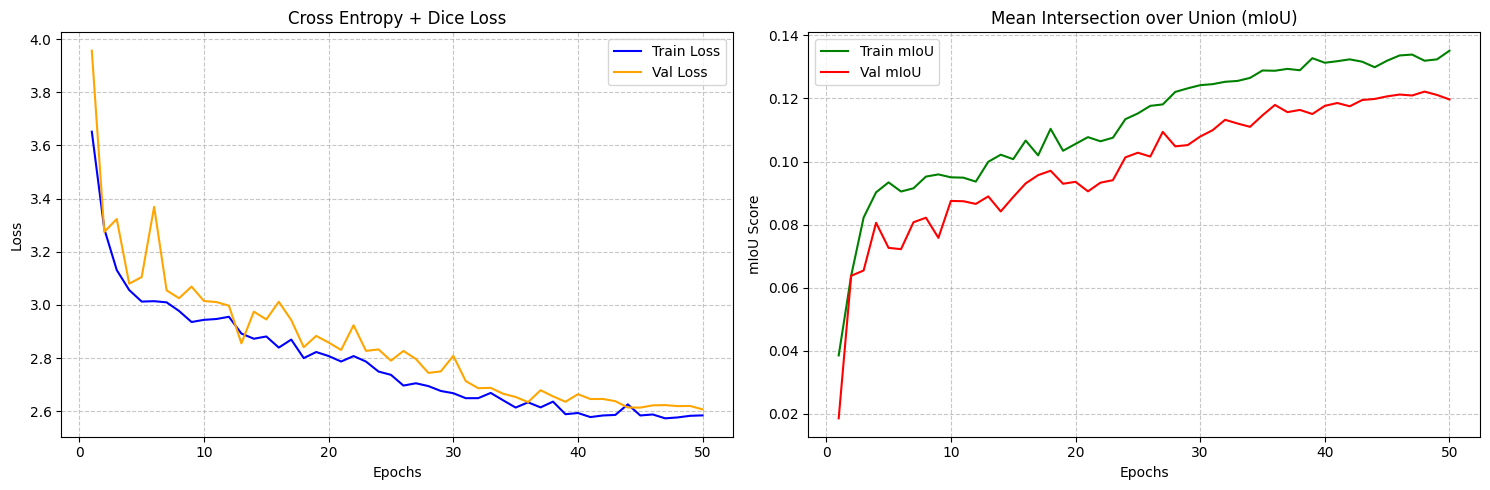

In [74]:
plot_learning_curves(train_history, val_history)

## Evaluation On Test Data

In [75]:
test_metrics = get_metrics(NUM_CLASSES, device)

test_loss, _ = validate(model, test_loader, test_metrics, criterion, device)
test_results = test_metrics.compute()

test_pix_acc = test_results['pixel_acc'].item()
test_dice = test_results['dice'].mean().item()
test_miou = test_results['miou'].mean().item()

print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Pixel Acc: {test_pix_acc:.2%}")
print(f"Test Mean Dice: {test_dice:.4f}")
print(f"Test mIoU:      {test_miou:.4f}")

Test Loss:      2.5658
Test Pixel Acc: 67.67%
Test Mean Dice: 0.1701
Test mIoU:      0.1296


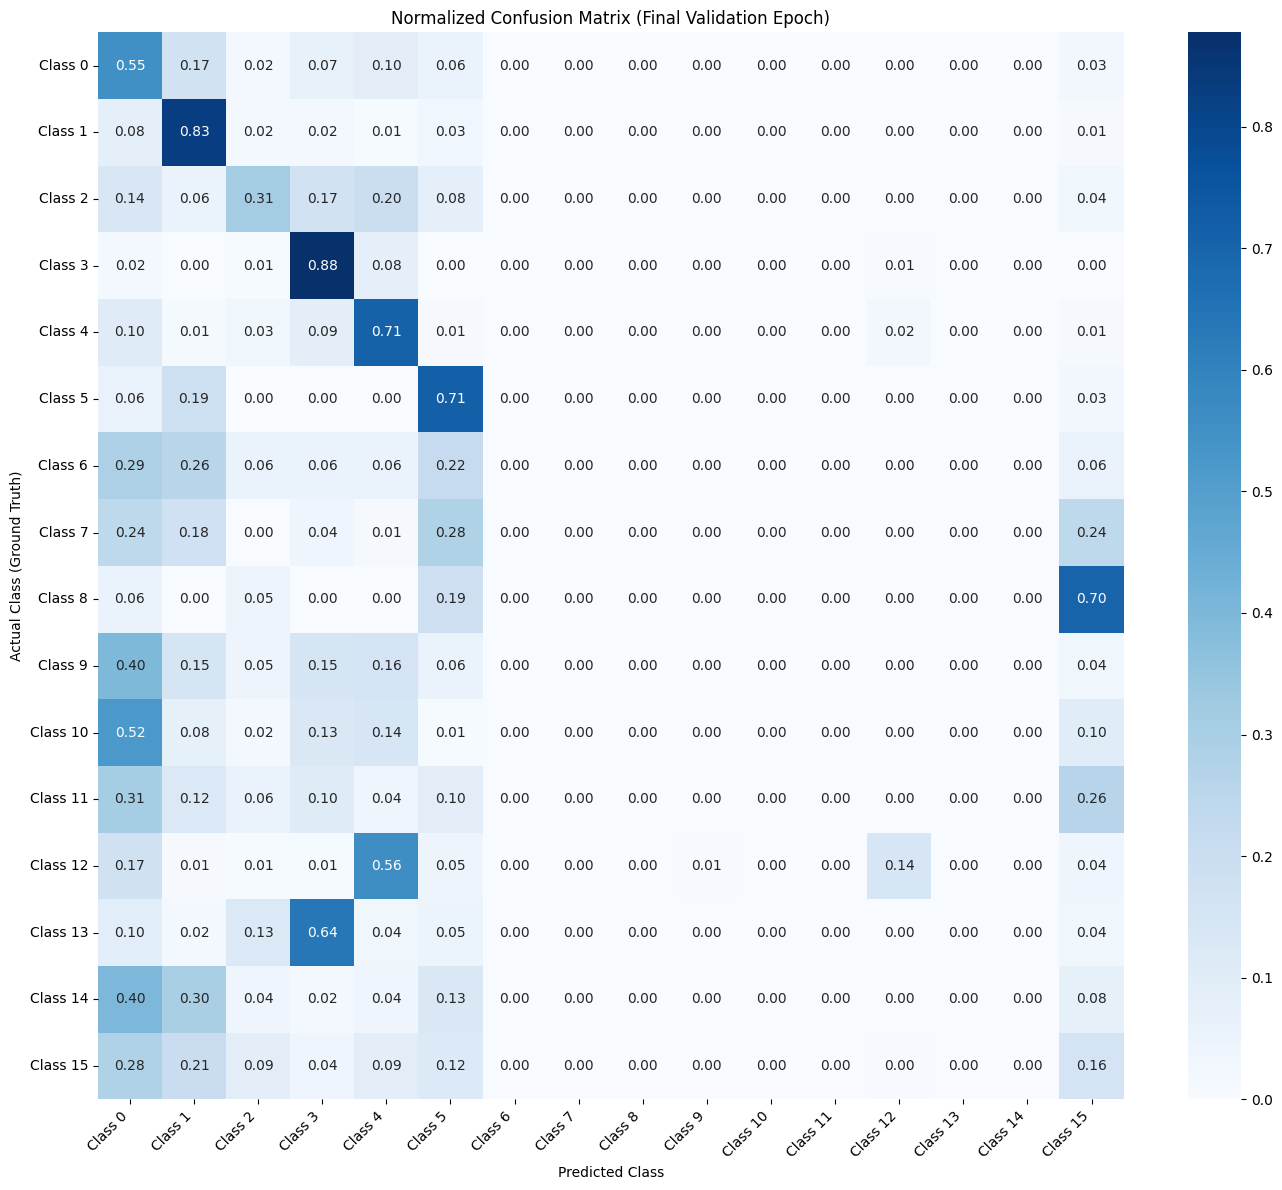

In [76]:
plot_confusion_matrix(test_results['conf_mat'])

/tmp/ipython-input-199614392.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=iou_array, palette="viridis")


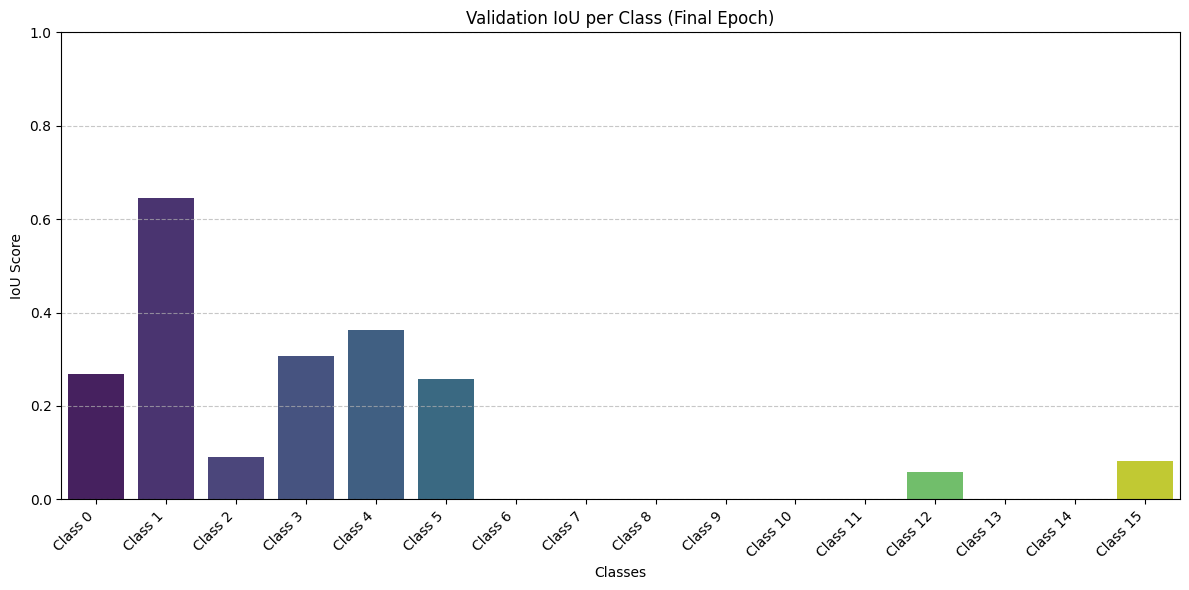

In [77]:
plot_per_class_iou(test_results['miou'].cpu().numpy())

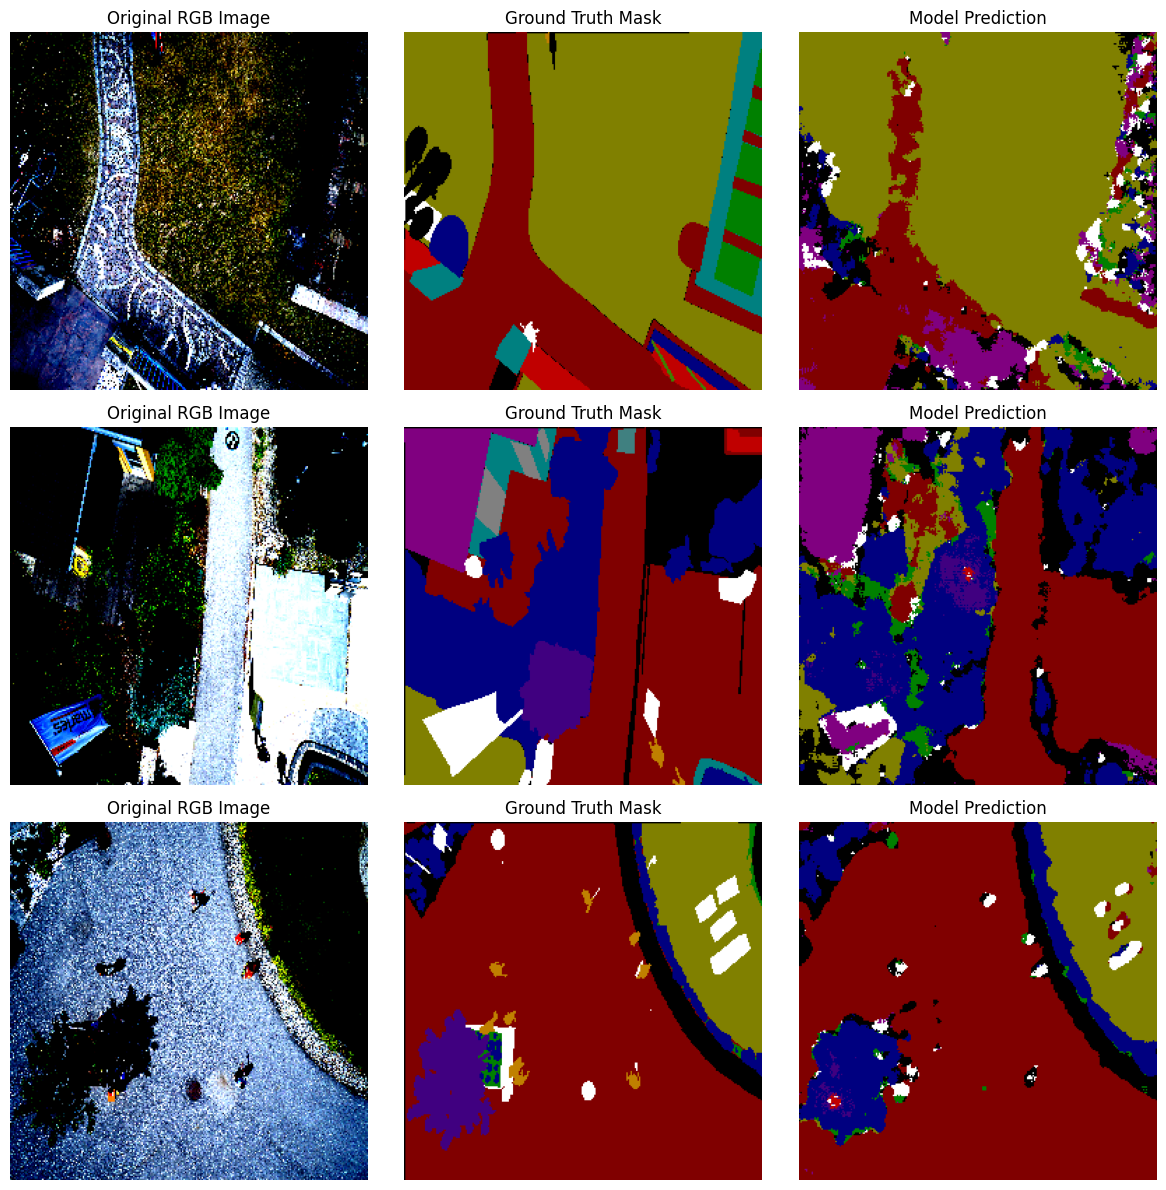

In [78]:
plot_qualitative_results(model, test_loader, device, num_images=3)